### Install and import the required packages

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time

In [2]:
# Installing pystan (may take around 8 minutes if the package is not in the environment yet)
t = time.time()
!pip install pystan==2.19.0.0
print('Time elapsed: {} seconds'.format(time.time() - t))

Time elapsed: 1.1754467487335205 seconds


In [3]:
import pystan

### Input your data of interest

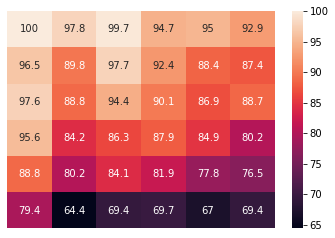

dosage 1:  [0.   0.   0.   0.   0.   0.   0.01 0.01 0.01 0.01 0.01 0.01 0.03 0.03
 0.03 0.03 0.03 0.03 0.1  0.1  0.1  0.1  0.1  0.1  0.3  0.3  0.3  0.3
 0.3  0.3  1.   1.   1.   1.   1.   1.  ]
dosage 2:  [ 0.    0.75  2.5   7.5  25.   75.    0.    0.75  2.5   7.5  25.   75.
  0.    0.75  2.5   7.5  25.   75.    0.    0.75  2.5   7.5  25.   75.
  0.    0.75  2.5   7.5  25.   75.    0.    0.75  2.5   7.5  25.   75.  ]
response:  [100.   97.8  99.7  94.7  95.   92.9  96.5  89.8  97.7  92.4  88.4  87.4
  97.6  88.8  94.4  90.1  86.9  88.7  95.6  84.2  86.3  87.9  84.9  80.2
  88.8  80.2  84.1  81.9  77.8  76.5  79.4  64.4  69.4  69.7  67.   69.4]


In [4]:
# For example:
dose_mat = np.array([[100., 97.8, 99.7, 94.7, 95., 92.9],
                     [96.5, 89.8, 97.7, 92.4, 88.4, 87.4],
                     [97.6, 88.8, 94.4, 90.1, 86.9, 88.7],
                     [95.6, 84.2, 86.3, 87.9, 84.9, 80.2],
                     [88.8, 80.2, 84.1, 81.9, 77.8, 76.5],
                     [79.4, 64.4, 69.4, 69.7, 67., 69.4]])
agent1_mono_dose = np.array([0., 1e-2, 3e-2, 0.1, 0.3, 1.])
agent2_mono_dose = np.array([0., 7.5e-1, 2.5, 7.5, 25., 75.])
plt.figure()
sns.heatmap(dose_mat, annot=True, xticklabels=False, yticklabels=False, fmt='g')
plt.show()
X1 = np.repeat(agent1_mono_dose, 6)
X2 = np.tile(agent2_mono_dose, 6)
Y = np.reshape(dose_mat, (36))
print('dosage 1: ', X1)
print('dosage 2: ', X2)
print('response: ', Y)

In [ ]:
# Alternatively, upload dataset in the form of a .csv file, where the first 
# column is named "dosage_1", the second column is named "dosage_2", and the 
# third column is named "response".
df = pd.read_csv("your_dose_response_data.csv")
X1 = df["dosage_1"]
X2 = df["dosage_2"]
Y = df["response"]

### Define the model according to Box 2 in the paper

#### Notes:
 - The prior for $E_0$ is defined to be Gaussian with mean $100$ and a standard deviation of $3$ (i.e. $B=100$ where $B$ is defined in the paper). But this may need to be changed according to the range of the responses in the dataset. For example, if the response range
 is between $0$ and $1$, then the prior for $E_0$ below shall be changed from `e0 ~ normal(100, 3)` to `e0 ~ normal(1, 0.03)`.
 To do this, define `e0_mean = 1` in the cell below.
 - The Beta prior for the normalised $\text{E}_{\text{inf}}$ is defined according to Option 2 in the paper. To opt for Option 1, define `einf_beta_a = 1` and `einf_beta_b = 1` in the cell below so that we have `einf ~ beta(1, 1)` which is equivalent to `einf ~ uniform(0, 1)`.
 - The bounds for the prior of $\log C$ are defined according to the dosage range of the AstraZeneca-Sanger DREAM challenge. Please refer to the paper for information on how to adjust the bounds (`ic50_lb` and `ic50_ub` in the cell below) if necessary.
 - The prior for $\sigma$ (the standard deviation of the i.i.d. noise) is defined to be lognormal(0, 1), where $\mu=0$ controls the median of the prior. It can be tuned depending on the range of $Y$ and the noise level expected by the user.
 For example, when the range of $Y$ is between $0$ and $100$, then a lognormal(0, 1) gives a median of 1.
 But when the range of $Y$ is between $0$ and $1$, then a smaller $\mu$ (e.g. somewhere between -5 and -4) may be more suitable.
 This could be determined by empirically estimating the noise level from an external dataset.
 To tune this, change the value of `sigma_mu` in the cell below.

In [5]:
# Define the parameters for the prior distributions
e0_mean = 100
einf_beta_a = 0.46
einf_beta_b = 0.58
ic50_lb = 1e-10
ic50_ub = 1e6
sigma_mu = 0

In [6]:
model = """
data {
  int<lower=0> N;
  int<lower=0> N_test;
  vector[N] X1;
  vector[N] X2;
  vector[N] Y;
  vector[N_test] X1_test;
  vector[N_test] X2_test;
  real<lower=0> e0_mean;
  real<lower=0> einf_beta_a;
  real<lower=0> einf_beta_b;
  real<lower=0> ic50_lb;
  real<lower=0> ic50_ub;
  real sigma_mu;
}
parameters {
  real<lower=0> e_0;
  real<lower=0, upper=1> e_1;
  real<lower=0, upper=1> e_2;
  real<lower=0, upper=1> e_3;
  real<lower=log(ic50_lb), upper=log(ic50_ub)> logC_1;
  real<lower=log(ic50_lb), upper=log(ic50_ub)> logC_2;
  real<lower=0> h_1;
  real<lower=0> h_2;
  real<lower=0> alpha;
  real<lower=0> sigma;
}
model {
    e_0 ~ normal(e0_mean, 0.03*e0_mean);
    e_1 ~ beta(einf_beta_a, einf_beta_b);
    e_2 ~ beta(einf_beta_a, einf_beta_b);
    e_3 ~ beta(einf_beta_a, einf_beta_b);
    h_1 ~ lognormal(0, 1);
    h_2 ~ lognormal(0, 1);
    alpha ~ lognormal(0, 1);
    sigma ~ lognormal(sigma_mu, 1);
    for(i in 1:N){
        Y[i] ~ normal(((exp(logC_1))^h_1 * (exp(logC_2))^h_2 * e_0 + X1[i]^h_1 * (exp(logC_2))^h_2 * e_1 * e_0 + X2[i]^h_2 * (exp(logC_1))^h_1 * e_2 * e_0 + alpha * X1[i]^h_1 * X2[i]^h_2 * e_3 * e_0) / ((exp(logC_1))^h_1 * (exp(logC_2))^h_2 + X1[i]^h_1 * (exp(logC_2))^h_2 + X2[i]^h_2 * (exp(logC_1))^h_1 + alpha * X1[i]^h_1 * X2[i]^h_2), sigma);
    }
}
generated quantities {
    vector[N_test] Y_synthetic;
    for(i in 1:N_test){
        Y_synthetic[i] = normal_rng(((exp(logC_1))^h_1 * (exp(logC_2))^h_2 * e_0 + X1_test[i]^h_1 * (exp(logC_2))^h_2 * e_1 * e_0 + X2_test[i]^h_2 * (exp(logC_1))^h_1 * e_2 * e_0 + alpha * X1_test[i]^h_1 * X2_test[i]^h_2 * e_3 * e_0) / ((exp(logC_1))^h_1 * (exp(logC_2))^h_2 + X1_test[i]^h_1 * (exp(logC_2))^h_2 + X2_test[i]^h_2 * (exp(logC_1))^h_1 + alpha * X1_test[i]^h_1 * X2_test[i]^h_2), sigma);
    }
}
"""

In [7]:
def synba_train(sm, X1, X2, Y, X1_test=None, X2_test=None, Y_test=None, iter=1000, e0_mean=100,
                einf_beta_a=0.46, einf_beta_b=0.58, ic50_lb=1e-10, ic50_ub=1e6,
                sigma_mu=0, chains=4, warmup=500, adapt_delta=0.9):
  N = len(Y)
  zero_ind_1 = np.where(X1 == 0)[0]
  zero_ind_2 = np.where(X2 == 0)[0]
  X1[zero_ind_1] = np.minimum(1e-8, 0.001 * np.min(X1[np.where(X1>0)[0]]))
  X2[zero_ind_2] = np.minimum(1e-8, 0.001 * np.min(X2[np.where(X2>0)[0]]))
  if X1_test is None:
    N_test, X1_test, X2_test = N, X1, X2
  data = {'N': N, 'X1': X1, 'X2': X2, 'Y': Y, 
          'N_test': N_test, 'X1_test': X1_test, 'X2_test': X2_test,
          'e0_mean': e0_mean, 'einf_beta_a': einf_beta_a, 'einf_beta_b': einf_beta_b,
          'ic50_lb': ic50_lb, 'ic50_ub': ic50_ub, 'sigma_mu': sigma_mu}
  fit = sm.sampling(data=data, iter=iter, chains=chains, warmup=warmup, thin=1, 
                    seed=101, control=dict(adapt_delta=adapt_delta))
  return fit

### Compile and train the model

In [ ]:
# Compile the model (may take around 1-2 minutes)
# Note: This cell only needs to be run once! As long as the definition for the
# model above is unchanged, this cell does not need to be repeated, even for
# different datasets.
t = time.time()
sm = pystan.StanModel(model_code=model)
print('Time taken to compile the model: {} seconds'.format(time.time() - t))

In [9]:
# Fit the model and generate samples
t = time.time()
fit = synba_train(sm, X1, X2, Y, e0_mean=e0_mean,
                einf_beta_a=einf_beta_a, einf_beta_b=einf_beta_b,
                ic50_lb=ic50_lb, ic50_ub=ic50_ub,
                sigma_mu=sigma_mu)
print('Time taken to fit the model: {} seconds'.format(time.time() - t))




Gradient evaluation took 0.000119 seconds
Gradient evaluation took 0.000119 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.19 seconds.
1000 transitions using 10 leapfrog steps per transition would take 1.19 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!




Gradient evaluation took 0.000113 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.13 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000112 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.12 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (W

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter is inf, but must be finite!  (in 'unknown file name' at line 39)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


Exception: normal_lpdf: Location parameter is inf, but must be finite!  (in 'unknown file name' at line 39)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected

### Output Analysis

#### Summary statistics

Note: The "e_1", "e_2" and "e_3" in the summary table are normalised, so their ranges are (0, 1) instead of (0, e_0).

In [10]:
# diagnostics
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], columns=summary_dict['summary_colnames'],
                  index=summary_dict['summary_rownames'])
# Extracting traces
e_0, e_1, e_2, e_3 = fit['e_0'], fit['e_1'], fit['e_2'], fit['e_3']
logC_1, logC_2, h_1, h_2 = fit['logC_1'], fit['logC_2'], fit['h_1'], fit['h_2']
alpha, sigma = fit['alpha'], fit['sigma']

print(fit.stansummary())

Inference for Stan model: anon_model_1c931a5451211e7706e36f3731253ef1.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
e_0             100.86    0.05   1.81  97.43  99.61 100.81 102.06 104.53   1132    1.0
e_1               0.24  7.5e-3   0.22 5.2e-4   0.05   0.19   0.39   0.75    865    1.0
e_2               0.82    0.01   0.21   0.07   0.77    0.9   0.94   0.98    241   1.02
e_3               0.16  4.8e-3   0.16 2.1e-4   0.02    0.1   0.25   0.53   1116   1.01
logC_1            1.86    0.04    1.0  -0.15   1.26   1.91    2.4   3.95    505    1.0
logC_2           -0.65    0.49   9.69  -18.1  -8.57  -0.31   8.16  13.29    398    1.0
h_1               0.58  2.9e-3   0.09   0.44   0.52   0.57   0.63   0.78    877    1.0
h_2               0.63    0.05   1.21   0.08   0.16   0.23   0.49   4.01    634    1.0
alpha             2.28    0.05

#### Visualisation of the synergy

1. The contour plot for the joint posterior distribution of the synergistic efficacy (ΔHSA) and the synergistic potency (log(α)). The distribution is smoothed from the empirical posterior with a kernel density estimation for visualisation purpose.

2. The histogram of the synergistic efficacy (ΔHSA). The area on the right hand side of the red vertical line is the probability that the combination is synergistic in terms of efficacy.

3. The histogram of synergistic potency (log(α)). The area on the right hand side of the red vertical line is the probability that the combination is synergistic in terms of potency.

First quadrant: The combination is synergistic in terms of both potency and efficacy.
Second quadrant: The combination is synergistic in terms of efficacy but not potency.
Third quadrant: The combination is synergistic in terms of potency but not efficacy.
Fourth quadrant: The combination is not synergistic in terms of either potency or efficacy.
P(the combination is synergistic in terms of both potency and efficacy) = 52.55%
P(the combination is synergistic in terms of efficacy but not potency) = 10.91%
P(the combination is synergistic in terms of potency but not efficacy) = 33.93%
P(the combination is not synergistic in terms of either potency or efficacy) = 2.60%
P(the combination is synergistic in terms of efficacy) = P(Delta HSA>0) = 63.46%
P(the combination is synergistic in terms of potency) = P(alpha>1) = 86.49%


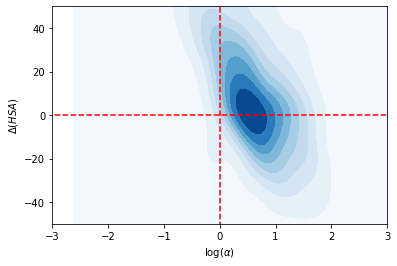

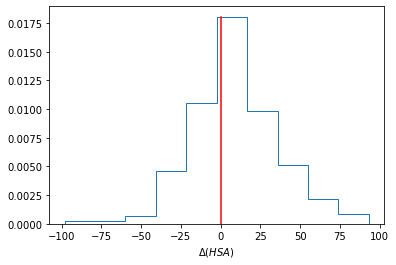

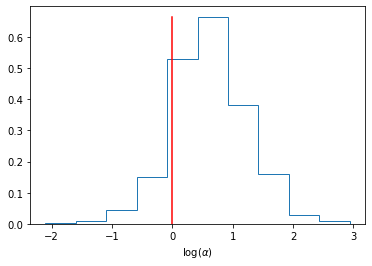

In [11]:
# Plot the posterior
e0, e1, e2, e3, alpha = fit['e_0'], fit['e_1'], fit['e_2'], fit['e_3'], fit['alpha']
delta_hsa = e0 * (np.minimum(e1, e2) - e3)

print('First quadrant: The combination is synergistic in terms of both potency and efficacy.')
print('Second quadrant: The combination is synergistic in terms of efficacy but not potency.')
print('Third quadrant: The combination is synergistic in terms of potency but not efficacy.')
print('Fourth quadrant: The combination is not synergistic in terms of either potency or efficacy.')

sns.kdeplot(x=np.log(alpha), y=delta_hsa, cmap="Blues", fill=True, # shade=True, shade_lowest=False,
            thresh=0, clip=((-5, 5), (-100, 100)))
sns.lineplot(x=[-5, 5], y=[0, 0], color='r', linewidth=1.5, linestyle='--')
sns.lineplot(x=[0, 0], y=[-100, 100], color='r', linewidth=1.5, linestyle='--', estimator=None)
plt.xlabel(r'$\log(\alpha)$')
plt.ylabel(r'$\Delta(HSA)$')
plt.xlim([-3, 3])
plt.ylim([-50, 50])
plt.show()

delta_hsa = 100 * (np.minimum(e1[1000:-1], e2[1000:-1]) - e3[1000:-1])
alpha_vec = alpha[1000:-1]

print('P(the combination is synergistic in terms of both potency and efficacy) = {:.2f}%'.format(
      100*len(np.intersect1d(np.where(delta_hsa > 0)[0], np.where(alpha_vec > 1)[0]))/len(delta_hsa)))
print('P(the combination is synergistic in terms of efficacy but not potency) = {:.2f}%'.format(
      100*len(np.intersect1d(np.where(delta_hsa > 0)[0], np.where(alpha_vec < 1)[0]))/len(delta_hsa)))
print('P(the combination is synergistic in terms of potency but not efficacy) = {:.2f}%'.format(
      100*len(np.intersect1d(np.where(delta_hsa < 0)[0], np.where(alpha_vec > 1)[0]))/len(delta_hsa)))
print('P(the combination is not synergistic in terms of either potency or efficacy) = {:.2f}%'.format(
      100*len(np.intersect1d(np.where(delta_hsa < 0)[0], np.where(alpha_vec < 1)[0]))/len(delta_hsa)))

plt.plot()
val, _, _ = plt.hist(delta_hsa, density=True, histtype='step')
plt.plot([0, 0], [0, np.max(val)], color='r')
plt.xlabel(r'$\Delta(HSA)$')
plt.show()

print('P(the combination is synergistic in terms of efficacy) = P(Delta HSA>0) = {:.2f}%'.format(
      100*len(np.where(delta_hsa > 0)[0])/len(delta_hsa)))

plt.plot()
val, _, _ = plt.hist(np.log(alpha_vec), density=True, histtype='step')
plt.plot([0, 0], [0, np.max(val)], color='r')
plt.xlabel(r'$\log(\alpha)$')
plt.show()

print('P(the combination is synergistic in terms of potency) = P(alpha>1) = {:.2f}%'.format(
      100*len(np.where(alpha_vec > 1)[0])/len(alpha_vec)))